In [3]:
import numpy as np
import librosa
import glob
import os
from random import randint
import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import matplotlib.pyplot as plt
from torch.autograd import Variable
%matplotlib inline

In [4]:
torch.cuda.set_device(3)
print(torch.cuda.current_device())

3


In [5]:
class SEN_classify(nn.Module):
    def __init__(self):
        super().__init__()
        self.siamese_cnn = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=[4,128],stride=[1,128]),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(128, 256, kernel_size=[4,1],stride=[1,1]),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=[4,1],stride=[1,1]),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            )
        #max_pool 注意保证padding="same"
        self.late_cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=[3,3],stride=[1,1]),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=[3,3],stride=[3,3],padding=1),
            
            nn.Conv2d(64, 128, kernel_size=[3,3],stride=[1,1]),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=[3,3],stride=[3,3],padding=[1,0]),

            nn.Conv2d(128, 256, kernel_size=[3,3],stride=[1,1]),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            )
        self.fcWithDropout = nn.Sequential(
            nn.Linear(768, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            nn.Linear(1024, 2),
            nn.Softmax(dim=1)
            )
    def cal_similarity(self,matrix1,matrix2):
        out1 = torch.squeeze(matrix1,dim=3)
        out2 = torch.squeeze(matrix2,dim=3)
        num = torch.bmm(torch.transpose(out1,1,2),out2)
        h1_norm = torch.sqrt(torch.sum(torch.mul(out1,out1), dim=1, keepdim=True))
        h2_norm = torch.sqrt(torch.sum(torch.mul(out2,out2), dim=1, keepdim=True))
        denom = torch.bmm(torch.transpose(h1_norm,1,2),h2_norm)
        fms = torch.unsqueeze(torch.div(num,denom),dim=1)
        return fms
    
    def _reduce_var(self,inputs):
        m1 = torch.mean(inputs,dim=2,keepdim=True)
        m = torch.mean(m1,dim=3,keepdim=True)
        devs_squared1 = torch.mul(inputs - m,inputs - m)
        devs_squared2 = torch.mean(devs_squared1,dim=2)
        devs_squared = torch.mean(devs_squared2,dim=2)
        return devs_squared

    def cal_global_pool(self,matrix):
        g_max1,_ = torch.max(matrix,dim=2)
        g_max,_ = torch.max(g_max1,dim=2)
        g_mean1 = torch.mean(matrix,dim=2)
        g_mean = torch.mean(g_mean1,dim=2)
        g_var = self._reduce_var(matrix)
        return torch.cat([g_max, g_mean, g_var], 1)
        
    def forward(self,x1,x2):
        out1 = self.siamese_cnn(x1)
        out2 = self.siamese_cnn(x2)
        similarity = self.cal_similarity(out1,out2)
        late_cnn_out = self.late_cnn(similarity)
        golbal_pool_out = self.cal_global_pool(late_cnn_out)
        predictions = self.fcWithDropout(golbal_pool_out)
        return predictions

In [7]:
SENmodel = SEN_classify().double()
state_dict = torch.load('../model/baseline_sen.pkl',map_location={'cuda:2':'cuda:3'})
SENmodel.load_state_dict(state_dict)
SENmodel = SENmodel.cuda()
SENmodel = SENmodel.eval()

In [14]:
# sample = 3000 
sample = 3200
sen_data = []
for song_num in range(int(sample/4)):
    token_train = "song{}_1,song{}_2".format(song_num,song_num)
    sen_data.append(token_train)
    
    token_train = "song{}_1,song{}_3".format(song_num,song_num)
    sen_data.append(token_train)
    
    token_train = "song{}_2,song{}_1".format(song_num,song_num)
    sen_data.append(token_train)
    
    token_train = "song{}_3,song{}_1".format(song_num,song_num)
    sen_data.append(token_train)
    
data_dir = "/media/data/cuixuange/ScrawlMusic/train_data_normalizatin/"
def load_exits_file(train_data,index):
    str_data = train_data[index].split(",")      
    x1_name = data_dir + str_data[0]+".npy"
    x2_name = data_dir + str_data[1]+".npy"
    if os.path.isfile(x1_name) and os.path.isfile(x2_name):
        return x1_name,x2_name,index
    else:
        index += 4
        return load_exits_file(train_data,index)

In [15]:
with torch.no_grad():
    def cal_similarity(matrix1,matrix2):
        out1 = torch.squeeze(matrix1,dim=3)
        out2 = torch.squeeze(matrix2,dim=3)
        num = torch.bmm(torch.transpose(out1,1,2),out2)
        h1_norm = torch.sqrt(torch.sum(torch.mul(out1,out1), dim=1, keepdim=True))
        h2_norm = torch.sqrt(torch.sum(torch.mul(out2,out2), dim=1, keepdim=True))
        denom = torch.bmm(torch.transpose(h1_norm,1,2),h2_norm)
        fms = torch.unsqueeze(torch.div(num,denom),dim=1)
        return fms

    def _reduce_var(inputs):
        m1 = torch.mean(inputs,dim=2,keepdim=True)
        m = torch.mean(m1,dim=3,keepdim=True)
        devs_squared1 = torch.mul(inputs - m,inputs - m)
        devs_squared2 = torch.mean(devs_squared1,dim=2)
        devs_squared = torch.mean(devs_squared2,dim=2)
        return devs_squared

    def cal_global_pool(matrix):
        g_max1,_ = torch.max(matrix,dim=2)
        g_max,_ = torch.max(g_max1,dim=2)
        g_mean1 = torch.mean(matrix,dim=2)
        g_mean = torch.mean(g_mean1,dim=2)
        g_var = _reduce_var(matrix)
        return torch.cat([g_max, g_mean, g_var], 1)

    def getLinearLayer(x1,x2):
        for name, module in SENmodel._modules.items():
            module = module.cuda()
            if(name == "siamese_cnn"):
                x1 = module(x1)
                x2 = module(x2)
                sim = cal_similarity(x1,x2)
            if(name == "late_cnn"):
                late_cnn_out = module(sim)
                golbal_pool_out = cal_global_pool(late_cnn_out)
            if(name == "fcWithDropout"):
                layer_out = module[0](golbal_pool_out)
                for i in range(1,8):
                    layer_out = module[i](layer_out)
                return layer_out

In [28]:
X_embedded = np.zeros((sample,1024))
Y_embedded = []

def getPart(data):
    p1 = data.split(",")[0][-1]
    p2 = data.split(",")[1][-1]
    return "P{}P{}".format(p1,p2)

for i in range(len(sen_data)):
    Y_embedded.append(getPart(sen_data[i]))
#     print(Y[i])

with torch.no_grad():
    for key,token in enumerate(sen_data):
        x1_name,x2_name,exit_index = load_exits_file(sen_data,key)
        X1 = torch.from_numpy(np.expand_dims(np.transpose(np.load(x1_name)),axis=2))
        X2 = torch.from_numpy(np.expand_dims(np.transpose(np.load(x2_name)),axis=2))
        X = torch.cat((X1,X2),dim=2)
        X = X.unsqueeze(0)
        X = X.unsqueeze(0) 
        x1 =torch.transpose((X[...,0]),2,3).cuda()
        x2 =torch.transpose((X[...,1]),2,3).cuda()
        predict_label = getLinearLayer(x1,x2).detach().cpu().numpy()
        X_embedded[key] = predict_label
        
    print(X_embedded[0])   

[ 0.57516479  0.335733    0.         ...,  0.03350693  0.15987356  0.        ]


In [18]:
np.save("./SEN_feature.npy",X_embedded)

In [38]:
import time
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

print(len(X_embedded))
print(len(sen_data))
pca_50 = PCA(n_components=20)
X_embedded_PCA = pca_50.fit_transform(X_embedded)
print("50个主要组成部分的累积解释变异: {}".format(np.sum(pca_50.explained_variance_ratio_)))


tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=300)
X_embedded2  = tsne.fit_transform(X_embedded_PCA)
print(X_embedded2.shape)


# df_new = pd.DataFrame(X_embedded2,columns=["x_location","y_location"])
# df_new["label"] = Y_embedded


3200
3200
50个主要组成部分的累积解释变异: 0.9913191846238546
(3200, 2)


   x_location  y_location label
0   -9.866523   -5.551732  P1P2
1   -4.557259   -3.499870  P1P3
2  -10.083235   -1.866992  P2P1
3  -11.132038   10.944284  P3P1
4  -11.423678    0.455930  P1P2


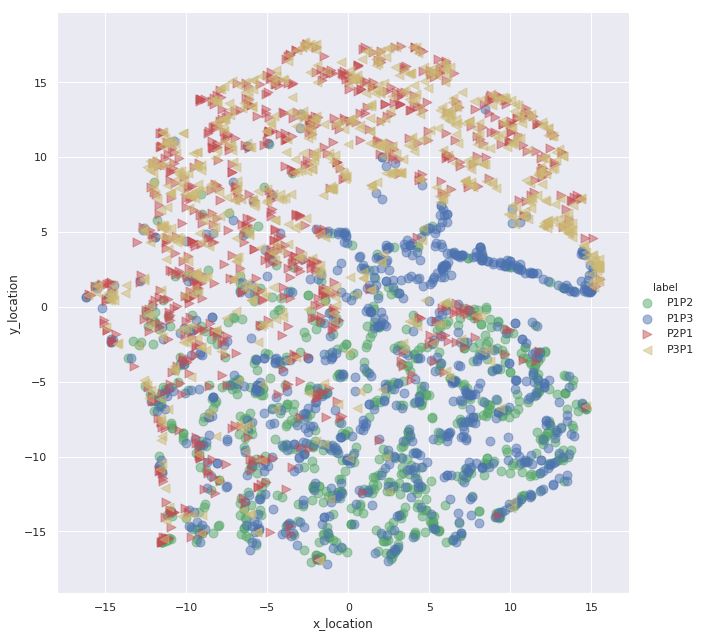

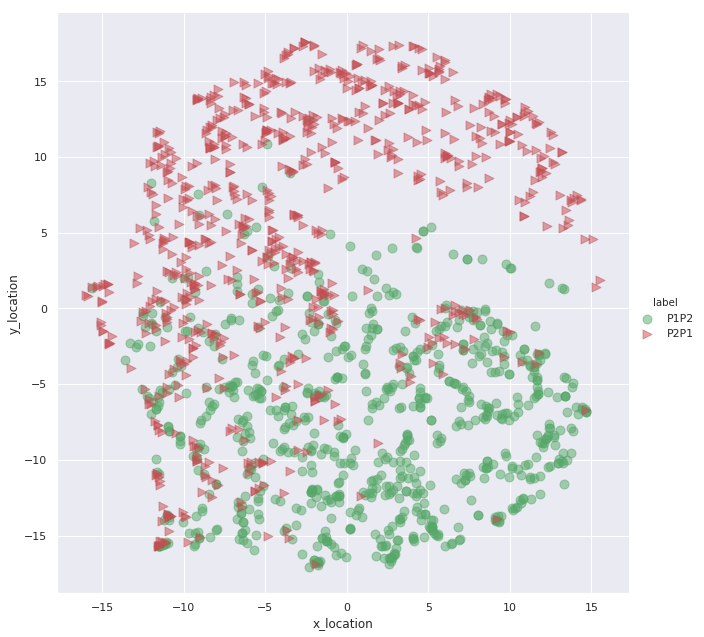

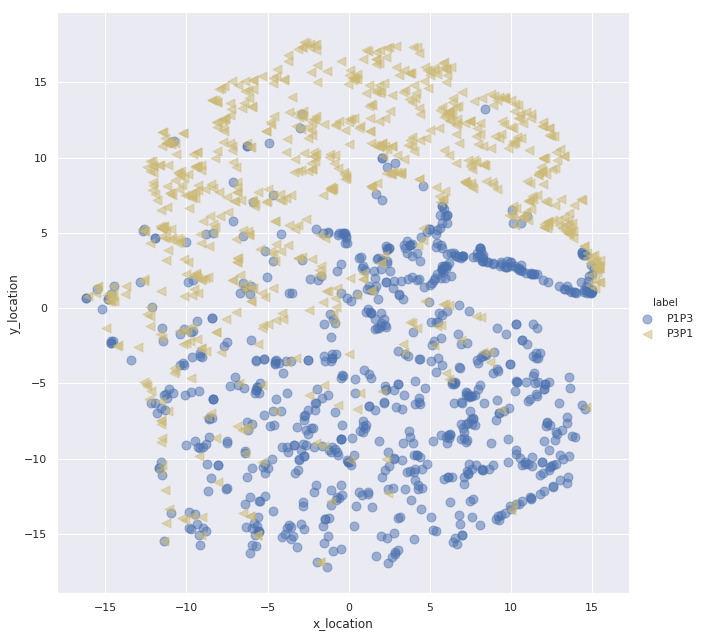

In [42]:
def getPart(data):
    p1 = data.split(",")[0][-1]
    p2 = data.split(",")[1][-1]
    return "P{}P{}".format(p1,p2)
Y_embedded = []
for i in range(len(sen_data)):
    Y_embedded.append(getPart(sen_data[i]))
print(df_new.head(5))

df_new = pd.DataFrame(X_embedded2,columns=["x_location","y_location"])
df_new["label"] = Y_embedded


sns.set()
mydict = {"P1P2":"g", "P2P1":"r","P1P3":"b","P3P1":"y"}
markers=["o", "o", ">","<"]
sns.lmplot(x='x_location',
           y='y_location',
           data=df_new,
           fit_reg=False,
           legend=True,
           truncate=True,
           markers=markers,
           height=9,
           hue='label',
           palette=mydict,
           scatter_kws={"s":80, "alpha":0.5})



mydict = {"P1P2":"g", "P2P1":"r"}
df_new1 = df_new.loc[(df_new['label'] != "P1P3") & (df_new['label'] != "P3P1")]
markers=["o", ">"]
sns.lmplot(x='x_location',
           y='y_location',
           data=df_new1,
           fit_reg=False,
           legend=True,
           truncate=True,
           markers=markers,
           height=9,
           hue='label',
           palette=mydict,
           scatter_kws={"s":80, "alpha":0.5})


mydict = {"P1P3":"b","P3P1":"y"}
df_new2 = df_new.loc[(df_new['label'] != "P1P2") & (df_new['label'] != "P2P1")]
markers=[ "o","<"]
sns.lmplot(x='x_location',
           y='y_location',
           data=df_new2,
           fit_reg=False,
           legend=True,
           truncate=True,
           markers=markers,
           height=9,
           hue='label',
           palette=mydict,
           scatter_kws={"s":80, "alpha":0.5})

In [44]:
with open("./sen_Y_embedded.txt","w") as file:
    for i in Y_embedded:
        file.write(i+"\n")